<a href="https://colab.research.google.com/github/AllanRodrigo/Data_Science_Alura/blob/main/Notebooks/Semana_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparando o Ambiente**

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=fac5d6f56f077d3ad990988d27e2a6e18c74e181bef4c7173166a46c83a81806
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

## **Preços de Imóveis - Transformados**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zipfile.ZipFile('/content/drive/MyDrive/curso-spark/semana-2.zip', 'r').extractall('/content/drive/MyDrive/curso-spark/semana_2')

In [5]:
path = '/content/drive/MyDrive/curso-spark/semana_2/dataset_transformado_parquet'
dados = spark.read.parquet(path)

In [6]:
dados.show(10)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|              bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+--------------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|            Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|               Irajá|  Zona Norte|       170|   0|Vend

## **Seleção de features**

In [7]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [8]:
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.sql import functions as f

In [9]:
dados\
    .select('tipo_anuncio')\
    .groupBy('tipo_anuncio')\
    .count()\
    .show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+



In [10]:
dados\
    .select('tipo_unidade')\
    .groupBy('tipo_unidade')\
    .count()\
    .show()

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+



In [11]:
dados\
    .select('tipo_uso')\
    .groupBy('tipo_uso')\
    .count()\
    .show()

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+



In [12]:
dados\
    .select('tipo')\
    .groupBy('tipo')\
    .count()\
    .show()

+-----+-----+
| tipo|count|
+-----+-----+
|Venda|66562|
+-----+-----+



In [13]:
dados = dados.select("id", "andar", "area_util", "banheiros", "caracteristicas", "quartos", \
             "suites", "vaga", "bairro", "zona", "condominio", "iptu", "valor")

## **Converter os tipos das colunas**

In [15]:
dados = dados.withColumn('area_util', dados['area_util'].cast(DoubleType()))\
                   .withColumn('condominio', dados['condominio'].cast(DoubleType()))\
                   .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
                   .withColumn('valor', dados['valor'].cast(DoubleType()))\
                   .withColumn('andar', dados['andar'].cast(IntegerType()))\
                   .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
                   .withColumn('quartos', dados['quartos'].cast(IntegerType()))\
                   .withColumn('suites', dados['suites'].cast(IntegerType()))

dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



## **Tratamento da coluna caracteristicas**

In [16]:
dados = dados.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))


## **Tratar dados nulos e NaN's**

In [17]:
colunas = ["id", "andar", "area_util", "banheiros", "quartos", \
             "suites", "vaga", "bairro", "zona", "condominio", "iptu", "valor"]

dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in colunas])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+



In [18]:
dados = dados\
    .select('*')\
    .na\
    .fill(0)

In [19]:
dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in colunas])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|      0|     0|   0|     0|   0|         0|   0|    0|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+



## **Preparação dos dados para machine learning**

In [20]:
dados\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



In [21]:
dados = dados\
    .where(f.col('zona') != '')

In [22]:
zona = dados\
    .groupBy('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

zona.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



In [23]:
caracteristicas = dados.select(dados.id,f.explode(dados.caracteristicas))
caracteristicas.groupBy('col').count().show()

+------------------+-----+
|               col|count|
+------------------+-----+
|Condomínio fechado|34980|
|        Playground|31854|
| Portão eletrônico|29323|
|           Piscina|33235|
|Animais permitidos|30617|
|      Portaria 24h|30360|
|          Elevador|43023|
|          Academia|27641|
|   Salão de festas|33582|
|     Churrasqueira|31737|
+------------------+-----+



In [24]:
caracteristicas = caracteristicas\
                .groupBy('id')\
                .pivot('col')\
                .agg(f.lit(1))\
                .na\
                .fill(0)
caracteristicas.show()

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|                 1|            1|                 0|       0|      1|         1|           0|                0|              1|
|afecddff-f4cc-4ab...|       1|               

In [25]:
dados = dados\
    .join(zona, 'id', how='inner')\
    .join(caracteristicas, 'id', how='left')
    #.drop('caracteristicas')\
    #.drop('zona')

# Limpar os dados nulos gerados pelo left join de caracteristicas
dados = dados\
    .select('*')\
    .na\
    .fill(0)

dados.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|   iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|

## **Salvar a base de dados em parquet**

In [26]:
dados.write.parquet(
    path='/content/drive/MyDrive/curso-spark/semana_2/modelo',
    mode='overwrite'
)

## **Preparação dos dados para os algoritmos do Spark MLlib**

In [27]:
from pyspark.ml.feature import VectorAssembler

In [28]:
dataset = dados.withColumnRenamed('valor','label')

In [31]:
X = [
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul',
    'Academia',
    'Animais permitidos',
    'Churrasqueira',
    'Condomínio fechado',
    'Elevador',
    'Piscina',
    'Playground',
    'Portaria 24h',
    'Portão eletrônico',
    'Salão de festas'
]

In [32]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [33]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [34]:
dataset_prep.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------+---------+
|features                                                                                         |label    |
+-------------------------------------------------------------------------------------------------+---------+
|(22,[1,2,3,4,5,6,7,11,16],[410.0,3.0,4.0,1.0,1.0,3300.0,5780.0,1.0,1.0])                         |4600000.0|
|(22,[0,1,2,3,5,6,7,9,13,16,20,21],[1.0,50.0,1.0,1.0,1.0,500.0,600.0,1.0,1.0,1.0,1.0,1.0])        |360000.0 |
|(22,[1,2,3,4,5,10,14,16,17],[148.0,4.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0])                             |1200000.0|
|(22,[1,2,3,6,7,11,16],[104.0,1.0,2.0,1010.0,272.0,1.0,1.0])                                      |750000.0 |
|(22,[1,2,3,5,6,7,11,16],[71.0,2.0,2.0,1.0,1312.0,360.0,1.0,1.0])                                 |1025000.0|
|[3.0,115.0,2.0,3.0,0.0,0.0,1904.0,3831.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0]|1100000.0|
|[0.0,65.0

## **Análise de correlação**

In [35]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [38]:
correlacao = Correlation.corr(dataset_prep, 'features').collect()[0][0]
correlacao

DenseMatrix(22, 22, [1.0, 0.0207, 0.0176, 0.0101, 0.0243, 0.0183, 0.0066, 0.0004, ..., 0.6478, 0.5141, 0.4308, 0.654, 0.7383, 0.4586, 0.3852, 1.0], False)

In [39]:
correlacao.toArray()

array([[ 1.00000000e+00,  2.06748857e-02,  1.75771533e-02,
         1.00834528e-02,  2.42741138e-02,  1.82718435e-02,
         6.61793025e-03,  3.81095579e-04,  3.54157220e-02,
        -9.34283198e-03,  1.13949699e-02, -1.45510872e-02,
         6.41111110e-02,  1.01639775e-01,  4.57692561e-02,
         9.17071035e-02,  7.19853276e-02,  4.35550202e-02,
         5.37283976e-02,  8.96649707e-02,  8.34316227e-02,
         5.86164288e-02],
       [ 2.06748857e-02,  1.00000000e+00,  6.71030551e-01,
         6.74075597e-01,  6.20128736e-01,  4.71928438e-01,
         4.56765657e-02,  2.13371390e-02, -1.03892024e-01,
        -1.70483530e-01,  1.20950909e-01,  3.97345272e-02,
         1.99696761e-03, -1.29998185e-02, -2.40512015e-02,
        -1.26055199e-02,  1.68407713e-02,  1.81253057e-02,
        -1.57595387e-02, -2.44674623e-02, -2.12857930e-03,
        -2.69092650e-02],
       [ 1.75771533e-02,  6.71030551e-01,  1.00000000e+00,
         6.49025360e-01,  7.39838048e-01,  4.45058514e-01,
    

In [40]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)
dataframe_correlacao

,andar,area_util,banheiros,quartos,suites,vaga,condominio,iptu,Zona Central,Zona Norte,...,Academia,Animais permitidos,Churrasqueira,Condomínio fechado,Elevador,Piscina,Playground,Portaria 24h,Portão eletrônico,Salão de festas
andar,1.000000,0.020675,0.017577,0.010083,0.024274,0.018272,0.006618,0.000381,0.035416,-0.009343,...,0.064111,0.101640,0.045769,0.091707,0.071985,0.043555,0.053728,0.089665,0.083432,0.058616
area_util,0.020675,1.000000,0.671031,0.674076,0.620129,0.471928,0.045677,0.021337,-0.103892,-0.170484,...,0.001997,-0.013000,-0.024051,-0.012606,0.016841,0.018125,-0.015760,-0.024467,-0.002129,-0.026909
banheiros,0.017577,0.671031,1.000000,0.649025,0.739838,0.445059,0.027187,0.013934,-0.125551,-0.164139,...,0.079297,-0.024390,0.042792,-0.005238,0.057131,0.099209,0.066366,-0.034960,-0.016546,0.055917
quartos,0.010083,0.674076,0.649025,1.000000,0.579925,0.430442,0.021653,0.017250,-0.162938,-0.120803,...,0.061307,-0.021058,0.061462,-0.000314,0.025627,0.082699,0.077723,-0.022521,-0.015703,0.060820
suites,0.024274,0.620129,0.739838,0.579925,1.000000,0.458184,0.029063,0.011829,-0.104032,-0.215537,...,0.242630,0.065539,0.185553,0.139081,0.120022,0.263923,0.188921,0.079988,0.089574,0.173720
vaga,0.018272,0.471928,0.445059,0.430442,0.458184,1.000000,0.025884,0.011981,-0.098276,-0.105648,...,0.139843,0.038555,0.131505,0.079485,0.061370,0.170348,0.133452,0.034900,0.046257,0.133180
condominio,0.006618,0.045677,0.027187,0.021653,0.029063,0.025884,1.000000,0.202201,-0.004423,-0.010104,...,0.014311,0.012585,0.005712,0.012319,0.013392,0.010022,0.009576,0.011997,0.006180,0.009138
iptu,0.000381,0.021337,0.013934,0.017250,0.011829,0.011981,0.202201,1.000000,-0.003640,-0.008720,...,0.003353,-0.001878,-0.003081,-0.005234,0.006515,0.002496,0.000790,-0.001196,-0.004486,0.001124
Zona Central,0.035416,-0.103892,-0.125551,-0.162938,-0.104032,-0.098276,-0.004423,-0.003640,1.000000,-0.061703,...,0.043132,0.055134,0.001724,0.047391,0.038072,0.013571,-0.003139,0.049465,0.043298,0.008493
Zona Norte,-0.009343,-0.170484,-0.164139,-0.120803,-0.215537,-0.105648,-0.010104,-0.008720,-0.061703,1.000000,...,-0.120985,-0.026065,-0.051152,-0.089705,-0.027810,-0.133985,-0.036614,-0.072619,-0.032144,-0.018691


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

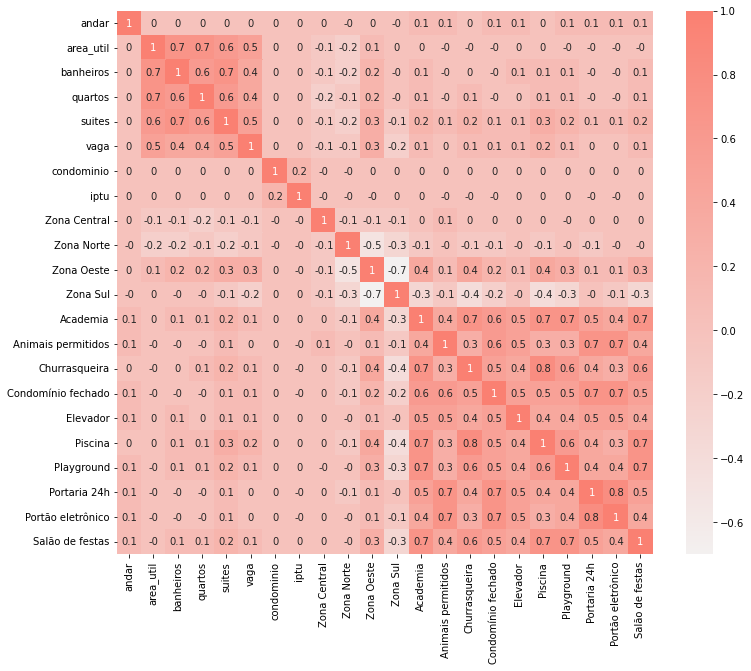

In [42]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

## **Criação dos modelos de regressão**

In [43]:
from pyspark.ml.regression import LinearRegression

In [44]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [45]:
treino.count()

46492

In [46]:
teste.count()

20059

In [47]:
lr = LinearRegression()

modelo_lr = lr.fit(treino)

previsoes_lr_treino = modelo_lr.transform(treino)

previsoes_lr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 445000.0| 698000.9989766502|
|(22,[0,1,2,3,4,5,...| 539000.0| 687687.7345221221|
|(22,[0,1,2,3,4,5,...| 262000.0| 773507.6602998237|
|(22,[0,1,2,3,4,5,...| 460000.0|255542.23532021226|
|(22,[0,1,2,3,4,5,...| 540000.0| 566899.6456831973|
|(22,[0,1,2,3,4,5,...|1047795.0| 671820.1002421915|
|(22,[0,1,2,3,4,5,...| 750000.0| 776164.8783146474|
|(22,[0,1,2,3,4,5,...| 795000.0|1021570.9164080797|
|(22,[0,1,2,3,4,5,...| 391000.0| 340617.4164378091|
|(22,[0,1,2,3,4,5,...| 473400.0| 463825.3932716036|
|(22,[0,1,2,3,4,5,...| 659900.0|473096.21000072174|
|(22,[0,1,2,3,4,5,...| 797204.0| 510947.2938758393|
|(22,[0,1,2,3,4,5,...| 499000.0| 765800.4226316279|
|(22,[0,1,2,3,4,5,...| 550000.0|1116040.3574794577|
|(22,[0,1,2,3,4,5,...|1400000.0|2119974.7634204626|
|(22,[0,1,2,3,4,5,...|2450000.0| 4262481.370301757|
|(22,[0,1,2,

## **Avaliação dos modelos**

In [48]:
resumo_treino = modelo_lr.summary

In [49]:
resumo_treino.r2

0.6635367027307726

In [50]:
resumo_treino.rootMeanSquaredError

855723.1693553913

In [51]:
resumo_teste = modelo_lr.evaluate(teste)

In [52]:
resumo_teste.r2

0.6698487129866729

In [53]:
resumo_teste.rootMeanSquaredError

841041.7912415836

In [54]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.663537
RMSE: 855723.169355

Dados de Teste
R²: 0.669849
RMSE: 841041.791242


## **Criando outro modelo de regressão**

In [74]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [60]:
gbt = GBTRegressor(maxDepth=7, seed=101)

In [61]:
modelo_gbt = gbt.fit(treino)

In [62]:
previsoes_gbt_treino = modelo_gbt.transform(treino)

In [63]:
previsoes_gbt_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 445000.0|360901.07434916083|
|(22,[0,1,2,3,4,5,...| 539000.0|343556.51655154536|
|(22,[0,1,2,3,4,5,...| 262000.0|518572.64272107196|
|(22,[0,1,2,3,4,5,...| 460000.0| 339163.1762975065|
|(22,[0,1,2,3,4,5,...| 540000.0| 723907.7540204101|
|(22,[0,1,2,3,4,5,...|1047795.0| 732898.1658348973|
|(22,[0,1,2,3,4,5,...| 750000.0| 658255.0302956625|
|(22,[0,1,2,3,4,5,...| 795000.0| 666639.0738967559|
|(22,[0,1,2,3,4,5,...| 391000.0|  349401.817246812|
|(22,[0,1,2,3,4,5,...| 473400.0|402096.11941523134|
|(22,[0,1,2,3,4,5,...| 659900.0| 676174.0939673113|
|(22,[0,1,2,3,4,5,...| 797204.0| 676174.0939673113|
|(22,[0,1,2,3,4,5,...| 499000.0| 636606.2544371673|
|(22,[0,1,2,3,4,5,...| 550000.0| 653534.7872111878|
|(22,[0,1,2,3,4,5,...|1400000.0|1181344.2914634168|
|(22,[0,1,2,3,4,5,...|2450000.0| 2216903.151239618|
|(22,[0,1,2,

## Avaliação do novo modelo

In [64]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "rmse"}))

0.8643466851437421
543349.9708206207


In [65]:
previsoes_gbt_teste = modelo_gbt.transform(teste)

In [66]:
previsoes_gbt_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 349000.0|339987.12208769395|
|(22,[0,1,2,3,4,5,...| 400000.0| 391793.0979233279|
|(22,[0,1,2,3,4,5,...| 318000.0|516776.35634886584|
|(22,[0,1,2,3,4,5,...| 335000.0|  534123.401593787|
|(22,[0,1,2,3,4,5,...| 950000.0| 795208.0643592149|
|(22,[0,1,2,3,4,5,...|1250000.0|1842371.9719201133|
|(22,[0,1,2,3,4,5,...| 355000.0|  349401.817246812|
|(22,[0,1,2,3,4,5,...| 300000.0| 505503.1770978189|
|(22,[0,1,2,3,4,5,...|1540000.0|1394159.8287766934|
|(22,[0,1,2,3,4,5,...| 290000.0|490642.09431872884|
|(22,[0,1,2,3,4,5,...| 750000.0| 621377.4337782311|
|(22,[0,1,2,3,4,5,...| 852288.0| 676174.0939673113|
|(22,[0,1,2,3,4,5,...| 940000.0| 675668.4421825217|
|(22,[0,1,2,3,4,5,...| 650000.0| 769828.2584433972|
|(22,[0,1,2,3,4,5,...| 750000.0|368409.50464247225|
|(22,[0,1,2,3,4,5,...| 650000.0| 543113.8134082743|
|(22,[0,1,2,

In [67]:
print('GBT Regressor')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}))

GBT Regressor
Dados de Treino
R²: 0.864347
RMSE: 543349.970821

Dados de Teste
R²: 0.812637
RMSE: 633581.410706


## **Otimização de hiperparâmetros**

In [55]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [68]:
gbt = GBTRegressor()

In [69]:
grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .addGrid(gbt.maxBins, [10, 32, 45]) \
    .build()

In [70]:
gbt_cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
    )

In [71]:
modelo_gbtt_cv = gbt_cv.fit(treino)

In [72]:
previsoes_gbt_cv_teste = modelo_gbtt_cv.transform(teste)

In [73]:
print('GBT Regressor')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_cv_teste, {evaluator.metricName: "rmse"}))

GBT Regressor
Sem Cross Validation
R²: 0.812637
RMSE: 633581.410706

Com Cross Validation
R²: 0.806234
RMSE: 644317.377760
